## Modelling infrastructure exposure and risk


This notebook forms the basis of "Hands-On 6" in the CCG course.

It uses the road network and flood dataset extracted in the previous tutorial.

1. Exposure - overlay sample flood extent with the network and estimate flood depth of exposure
2. Vulnerability - assume depth-damage curve (fragility curve) for the road and
   - show how the exposure is translated to damage
   - create a table with probability, flood depth, length exposed, fragility, cost/km, direct damage
4. Risk - show a risk calculation on the table and generate the result
5. Future risk - repeat with climate projections and compare with baseline

By the end of this tutorial you should be able to:
* Assess direct damage and indirect disruptions to infrastructure assets
* Apply the risk calculation to understand how to generate loss-probability curves
* Show how different flood hazards introduce uncertainty in risk estimations

In [1]:
# Imports from Python standard library
import os
from pathlib import Path

# see https://docs.python.org/3/library/glob.html
from glob import glob

# Imports from other Python packages
import geopandas as gpd

# numpy is used by pandas and geopandas to store data in efficient arrays
# we use it in this notebook to help with trapezoidal integration
# see https://numpy.org/
import numpy as np
import pandas as pd

# seaborn helps produce more complex plots
# see https://seaborn.pydata.org/
import seaborn as sns

from scipy.integrate import simpson

import snail.damages
import snail.intersection
import snail.io

from pyproj import Geod

# tqdm lets us show progress bars (and تقدّم means "progress" in Arabic)
# see https://tqdm.github.io/
from tqdm.notebook import tqdm

Change this to point to your data folder as in the previous tutorial:

In [2]:
data_folder = Path("/Users/ivannschlosser/Documents/oxford/ghana_tutorial")

### 1. Exposure


List all the hazard files in the `flood_layer` folder:

In [3]:
hazard_paths = sorted(
    glob(str(data_folder / "flood_layer/gha/wri_aqueduct_version_2/wri*.tif"))
)
hazard_files = pd.DataFrame({"path": hazard_paths})
hazard_files["key"] = [Path(path).stem for path in hazard_paths]
hazard_files, grids = snail.io.extend_rasters_metadata(hazard_files)

hazard_files.head(5)

,path,key,grid_id,bands
0,/Users/ivannschlosser/Documents/oxford/ghana_t...,wri_aqueduct-version_2-inuncoast_historical_wt...,0,"(1,)"
1,/Users/ivannschlosser/Documents/oxford/ghana_t...,wri_aqueduct-version_2-inuncoast_historical_wt...,0,"(1,)"
2,/Users/ivannschlosser/Documents/oxford/ghana_t...,wri_aqueduct-version_2-inuncoast_historical_wt...,0,"(1,)"
3,/Users/ivannschlosser/Documents/oxford/ghana_t...,wri_aqueduct-version_2-inuncoast_historical_wt...,0,"(1,)"
4,/Users/ivannschlosser/Documents/oxford/ghana_t...,wri_aqueduct-version_2-inuncoast_historical_wt...,0,"(1,)"


In [4]:
assert len(grids) == 1
grid = grids[0]

Read in roads again, then do intersections against all hazard scenarios.

In [5]:
roads_file = data_folder / "GHA_OSM_roads.gpkg"
roads = gpd.read_file(roads_file, layer="edges")
roads.head(2)

,osm_id,road_type,name,id,from_id,to_id,length_m,geometry
0,4790594,tertiary,Airport Road,roade_0,roadn_0,roadn_1,236.526837,"LINESTRING (-0.17544 5.60550, -0.17418 5.60555..."
1,4790599,tertiary,South Liberation Link,roade_1,roadn_2,roadn_10807,18.539418,"LINESTRING (-0.17889 5.59979, -0.17872 5.59977)"


In [6]:
# split roads along hazard data grid

# TODO top-level "overlay_rasters"
# TODO for vector in vectors / for raster in rasters "overlay_raster"


# push into split_linestrings, flag to disable
prepared = snail.intersection.prepare_linestrings(roads)

flood_intersections = snail.intersection.split_linestrings(prepared, grid)

# push into split_linestrings
flood_intersections = snail.intersection.apply_indices(
    flood_intersections, grid, index_i="i_0", index_j="j_0"
)

flood_intersections = snail.io.associate_raster_files(
    flood_intersections, hazard_files
)

# calculate the length of each stretch of road
# don't include in snail wrapper top-level function
geod = Geod(ellps="WGS84")
flood_intersections["length_m"] = flood_intersections.geometry.apply(
    geod.geometry_length
)

In [7]:
# save to file
output_file = os.path.join(
    data_folder,
    "results",
    str(roads_file.name).replace(".gpkg", "_edges___exposure.geoparquet"),
)

flood_intersections.to_parquet(output_file)

In [8]:
flood_intersections.columns

Index(['osm_id', 'road_type', 'name', 'id', 'from_id', 'to_id', 'length_m',
       'geometry', 'split', 'i_0',
       ...
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2050_rp01000-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00002-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00005-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00010-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00025-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00050-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00100-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00250-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00500-gha',
       'wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000-gha'],
      dtype='object', length=390)

In [9]:
data_cols = [col for col in flood_intersections.columns if "wri" in col]

In [10]:
# find any max depth and filter > 0
all_intersections = flood_intersections[
    flood_intersections[data_cols].max(axis=1) > 0
]
# subset columns
all_intersections = all_intersections.drop(
    columns=["osm_id", "name", "from_id", "to_id", "geometry", "i_0", "j_0"]
)
# melt and check again for depth
all_intersections = all_intersections.melt(
    id_vars=["id", "split", "road_type", "length_m"],
    value_vars=data_cols,
    var_name="key",
    value_name="depth_m",
).query("depth_m > 0")

all_intersections.head(5)

,id,split,road_type,length_m,key,depth_m
439,roade_1429,9,tertiary,153.153316,wri_aqueduct-version_2-inuncoast_historical_wt...,0.466355
440,roade_1429,10,tertiary,28.151241,wri_aqueduct-version_2-inuncoast_historical_wt...,1.349324
444,roade_1447,9,tertiary,412.834012,wri_aqueduct-version_2-inuncoast_historical_wt...,0.006246
450,roade_1452,3,primary,929.965564,wri_aqueduct-version_2-inuncoast_historical_wt...,0.516396
452,roade_1452,5,primary,921.598630,wri_aqueduct-version_2-inuncoast_historical_wt...,0.407549


In [11]:
river = all_intersections[all_intersections.key.str.contains("inunriver")]
coast = all_intersections[all_intersections.key.str.contains("inuncoast")]

coast_keys = coast.key.str.extract(
    r"wri_aqueduct-version_2-(?P<hazard>\w+)_(?P<rcp>[^_]+)_(?P<sub>[^_]+)_(?P<epoch>[^_]+)_rp(?P<rp>[^-]+)-gha"
)
coast = pd.concat([coast, coast_keys], axis=1)
river_keys = river.key.str.extract(
    r"wri_aqueduct-version_2-(?P<hazard>\w+)_(?P<rcp>[^_]+)_(?P<gcm>[^_]+)_(?P<epoch>[^_]+)_rp(?P<rp>[^-]+)-gha"
)
river = pd.concat([river, river_keys], axis=1)

In [12]:
coast.rp = coast.rp.apply(lambda rp: float(rp.replace("_", ".").lstrip("0")))
coast.head(5)

,id,split,road_type,length_m,key,depth_m,hazard,rcp,sub,epoch,rp
439,roade_1429,9,tertiary,153.153316,wri_aqueduct-version_2-inuncoast_historical_wt...,0.466355,inuncoast,historical,wtsub,2030,1.5
440,roade_1429,10,tertiary,28.151241,wri_aqueduct-version_2-inuncoast_historical_wt...,1.349324,inuncoast,historical,wtsub,2030,1.5
444,roade_1447,9,tertiary,412.834012,wri_aqueduct-version_2-inuncoast_historical_wt...,0.006246,inuncoast,historical,wtsub,2030,1.5
450,roade_1452,3,primary,929.965564,wri_aqueduct-version_2-inuncoast_historical_wt...,0.516396,inuncoast,historical,wtsub,2030,1.5
452,roade_1452,5,primary,921.598630,wri_aqueduct-version_2-inuncoast_historical_wt...,0.407549,inuncoast,historical,wtsub,2030,1.5


In [13]:
# river.rp = river.rp.apply(lambda rp: float(rp.replace("_", ".").lstrip("0")))
river.gcm = river.gcm.str.replace("0", "")
river.head(5)

,id,split,road_type,length_m,key,depth_m,hazard,rcp,gcm,epoch,rp
550753,roade_56,0,trunk,256.660267,wri_aqueduct-version_2-inunriver_historical_00...,2.243539,inunriver,historical,WATCH,1980,00005
550755,roade_126,0,trunk,364.644366,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005
550756,roade_126,1,trunk,158.050565,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005
550757,roade_127,0,trunk,54.297481,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005
550758,roade_128,0,trunk,715.652789,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005


Summarise total length of roads exposed to depth 2m or greater river flooding, under different return periods and climate scenarios:


In [14]:
summary = (
    river[river.depth_m >= 2.0]
    .drop(columns=["id", "split", "road_type", "key"])
    .groupby(["hazard", "rcp", "gcm", "epoch", "rp"])
    .sum()
    .drop(columns=["depth_m"])
)

summary

length_m
hazard    rcp        gcm       epoch rp                  
inunriver historical WATCH     1980  00005  278980.836489
                                     00010  461345.618367
                                     00025  521049.572286
                                     00050  557202.826411
                                     00100  589840.619653
...                                                   ...
          rcp8p5     NorESM1-M 2080  00050  306812.495606
                                     00100  346457.694544
                                     00250  408674.849110
                                     00500  506771.887795
                                     01000  574607.043246

[208 rows x 1 columns]

Plot exposure against return period, with separate plot areas for each Representative Concentration Pathway (RCP), and different colours for the different Global Climate Models (GCM): 

In [15]:
plot_data = summary.reset_index()
plot_data = plot_data[plot_data.epoch.isin(["1980", "2080"])]
plot_data.rp = plot_data.rp.apply(lambda rp: int(rp.lstrip("0")))
plot_data["probability"] = 1 / plot_data.rp
plot_data.head(5)

,hazard,rcp,gcm,epoch,rp,length_m,probability
0,inunriver,historical,WATCH,1980,5,278980.836489,0.20
1,inunriver,historical,WATCH,1980,10,461345.618367,0.10
2,inunriver,historical,WATCH,1980,25,521049.572286,0.04
3,inunriver,historical,WATCH,1980,50,557202.826411,0.02
4,inunriver,historical,WATCH,1980,100,589840.619653,0.01


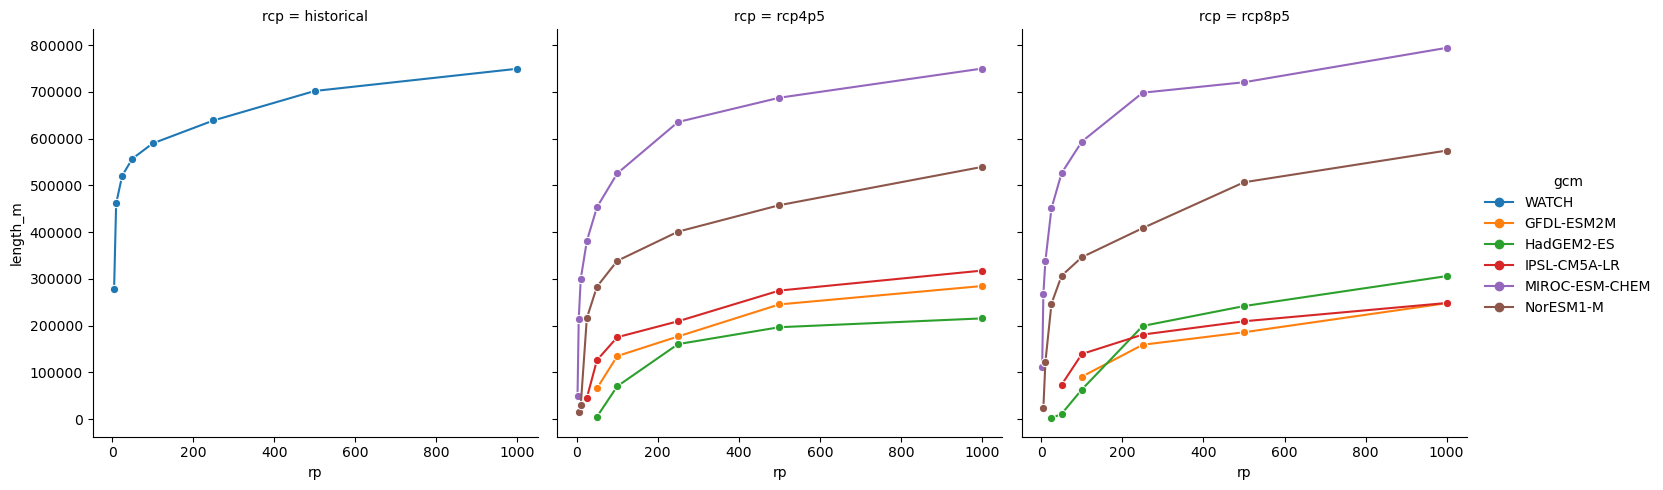

In [16]:
sns.relplot(
    data=plot_data,
    x="rp",
    y="length_m",
    hue="gcm",
    col="rcp",
    kind="line",
    marker="o",
)

### 2. Vulnerability

Set up fragility curve assumptions, where probability of damage (`pfail`) depends on whether a road is paved and the depth of flood it is exposed to. 

These assumptions are derived from Koks, E.E., Rozenberg, J., Zorn, C. et al. A global multi-hazard risk analysis of road and railway infrastructure assets. Nat Commun 10, 2677 (2019). https://doi.org/10.1038/s41467-019-10442-3, Figure S3, extrapolated to 2m and 3m depths. 

The analysis is likely to be highly sensitive to these assumptions, and this approach is strongly limited by the availability and quality of fragility data, as well as the assumption that fragility can be related to flood depth alone - flood water velocity would be an important factor in a more detailed vulnerability assessment. 

In [17]:
paved = snail.damages.PiecewiseLinearDamageCurve(
    pd.DataFrame(
        {
            "intensity": [0.0, 0.999999999, 1, 2, 3],
            "damage": [0.0, 0.0, 0.1, 0.3, 0.5],
        }
    )
)
unpaved = snail.damages.PiecewiseLinearDamageCurve(
    pd.DataFrame(
        {
            "intensity": [0.0, 0.999999999, 1, 2, 3],
            "damage": [0.0, 0.0, 0.9, 1.0, 1.0],
        }
    )
)
paved, unpaved

(<snail.damages.PiecewiseLinearDamageCurve at 0x2ad859850>,
 <snail.damages.PiecewiseLinearDamageCurve at 0x2ad72a750>)

(<Axes: xlabel='Hazard Intensity', ylabel='Damage Fraction'>,
 <Axes: xlabel='Hazard Intensity', ylabel='Damage Fraction'>)

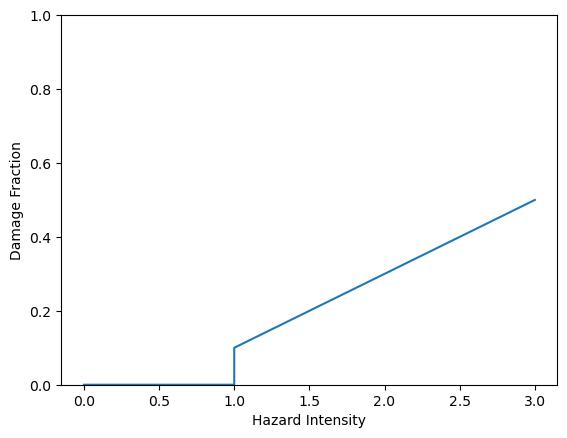

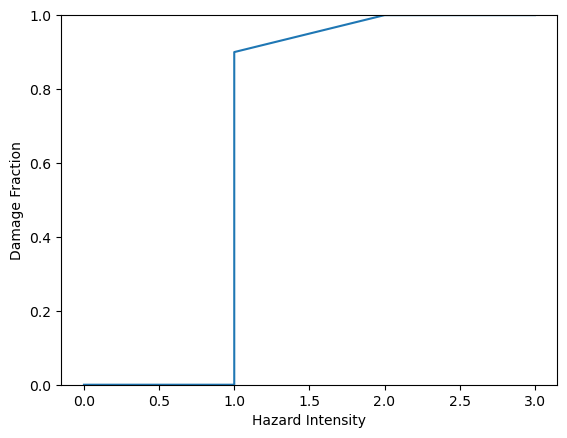

In [18]:
paved.plot(), unpaved.plot()

Set up cost assumptions. 

These are taken from Koks et al (2019) again, Table S8, construction costs to be assumed as an estimate of full rehabilitation after flood damage. 

Again the analysis is likely to be highly sensitive to these assumptions, which should be replaced by better estimates if available.

In [19]:
costs = pd.DataFrame(
    {
        "kind": ["paved_four_lane", "paved_two_lane", "unpaved"],
        "cost_usd_per_km": [3_800_000, 932_740, 22_780],
    }
)
costs

,kind,cost_usd_per_km
0,paved_four_lane,3800000
1,paved_two_lane,932740
2,unpaved,22780


Set up assumptions about which roads are paved or unpaved, and number of lanes.

In [20]:
sorted(river.road_type.unique())

['motorway',
 'motorway_link',
 'primary',
 'primary_link',
 'secondary',
 'secondary_link',
 'tertiary',
 'tertiary_link',
 'trunk',
 'trunk_link']

Assume all `tertiary` roads are unpaved, all others are paved.

In [21]:
river["paved"] = ~(river.road_type == "tertiary")

In [22]:
def kind(road_type):
    if road_type in ("trunk", "trunk_link", "motorway"):
        return "paved_four_lane"
    elif road_type in ("primary", "primary_link", "secondary"):
        return "paved_two_lane"
    else:
        return "unpaved"


river["kind"] = river.road_type.apply(kind)

In [23]:
river = river.merge(costs, on="kind")

Use the damage curve to estimate `proportion_damaged` for each exposed section.

In [24]:
river.head(2)

,id,split,road_type,length_m,key,depth_m,hazard,rcp,gcm,epoch,rp,paved,kind,cost_usd_per_km
0,roade_56,0,trunk,256.660267,wri_aqueduct-version_2-inunriver_historical_00...,2.243539,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000
1,roade_126,0,trunk,364.644366,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000


In [25]:
paved_depths = river.loc[river.paved, "depth_m"]
paved_damage = paved.damage_fraction(paved_depths)
river.loc[river.paved, "proportion_damaged"] = paved_damage

unpaved_depths = river.loc[~river.paved, "depth_m"]
unpaved_damage = paved.damage_fraction(unpaved_depths)
river.loc[~river.paved, "proportion_damaged"] = unpaved_damage

Finally estimate cost of rehabilitation for each exposed section

In [26]:
river["damage_usd"] = river.length_m * river.cost_usd_per_km * 1e-3
river.head(2)

,id,split,road_type,length_m,key,depth_m,hazard,rcp,gcm,epoch,rp,paved,kind,cost_usd_per_km,proportion_damaged,damage_usd
0,roade_56,0,trunk,256.660267,wri_aqueduct-version_2-inunriver_historical_00...,2.243539,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000,0.348708,9.753090e+05
1,roade_126,0,trunk,364.644366,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000,0.000000,1.385649e+06


In [27]:
river.to_csv(
    os.path.join(data_folder, "results/inunriver_damages_rp.csv"), index=False
)

In [28]:
summary = (
    river.drop(
        columns=[
            "id",
            "split",
            "length_m",
            "key",
            "depth_m",
            "paved",
            "kind",
            "cost_usd_per_km",
            "proportion_damaged",
        ]
    )
    .groupby(["road_type", "hazard", "rcp", "gcm", "epoch", "rp"])
    .sum()
)
summary

damage_usd
road_type  hazard    rcp        gcm       epoch rp                 
motorway   inunriver historical WATCH     1980  00005  2.848229e+07
                                                00010  2.848229e+07
                                                00025  2.848229e+07
                                                00050  2.848229e+07
                                                00100  2.848229e+07
...                                                             ...
trunk_link inunriver rcp8p5     NorESM1-M 2080  00050  1.473414e+07
                                                00100  1.473414e+07
                                                00250  1.473414e+07
                                                00500  1.473414e+07
                                                01000  1.473414e+07

[2780 rows x 1 columns]

### 3. Risk

Calculate expected annual damages for each road under historical hazard.

Start by selecting only historical intersections, and keeping only the road ID, return period, and cost of rehabilitation if damaged.

In [29]:
historical = river[river.rcp == "historical"][["id", "rp", "damage_usd"]]

Sum up the expected damage for each road, per return period, then pivot the table to create columns for each return period - now there is one row per road.

In [30]:
historical = historical.groupby(["id", "rp"]).sum().reset_index()
historical = historical.pivot(index="id", columns="rp").replace(
    float("NaN"), 0
)
historical.columns = [f"rp{int(rp)}" for _, rp in historical.columns]
historical.head(2)

,rp5,rp10,rp25,rp50,rp100,rp250,rp500,rp1000
id,,,,,,,,
roade_1002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5788.380563
roade_10029,46079.916698,46079.916698,46079.916698,46079.916698,46079.916698,46079.916698,46079.916698,46079.916698


Calculate expected annual damages, integrating under the expected damage curve over return periods.

In [31]:
def calculate_ead(df):
    rp_cols = sorted(
        list(df.columns), key=lambda col: 1 / int(col.replace("rp", ""))
    )
    rps = np.array([int(col.replace("rp", "")) for col in rp_cols])
    probabilities = 1 / rps
    rp_damages = df[rp_cols]
    return simpson(rp_damages, x=probabilities, axis=1)


historical["ead_usd"] = calculate_ead(historical)
historical.head(2)

,rp5,rp10,rp25,rp50,rp100,rp250,rp500,rp1000,ead_usd
id,,,,,,,,,
roade_1002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5788.380563,0.000000
roade_10029,46079.916698,46079.916698,46079.916698,46079.916698,46079.916698,46079.916698,46079.916698,46079.916698,9169.903423


In [32]:
historical.to_csv(
    os.path.join(data_folder, "results/inunriver_damages_ead__historical.csv")
)

### 4. Future risk

Calculate expected annual damages under each future scenario (for each global climate model and representative concentration pathway).

This follows the same method as for historical flooding above, with the added variables of climate model and rcp.

In [33]:
future = river[["id", "rp", "rcp", "gcm", "epoch", "damage_usd"]].copy()

Sum up the expected damage for each road, per return period, gcm and rcp

In [34]:
future = (
    future.groupby(["id", "rp", "rcp", "gcm", "epoch"]).sum().reset_index()
)
future.head(2)

,id,rp,rcp,gcm,epoch,damage_usd
0,roade_1002,00005,rcp8p5,MIROC-ESM-CHEM,2080,5788.380563
1,roade_1002,00010,rcp8p5,MIROC-ESM-CHEM,2050,5788.380563


Pivot the table to create columns for each return period - now there is one row per road, gcm and rcp.

In [35]:
future = future.pivot(
    index=["id", "rcp", "gcm", "epoch"], columns="rp"
).replace(float("NaN"), 0)
future.columns = [f"rp{int(rp)}" for _, rp in future.columns]
future.head(2)

rp2  rp5  rp10  rp25  rp50  rp100  \
id         rcp        gcm            epoch                                      
roade_1002 historical WATCH          1980   0.0  0.0   0.0   0.0   0.0    0.0   
           rcp4p5     MIROC-ESM-CHEM 2030   0.0  0.0   0.0   0.0   0.0    0.0   

                                                  rp250        rp500  \
id         rcp        gcm            epoch                             
roade_1002 historical WATCH          1980      0.000000     0.000000   
           rcp4p5     MIROC-ESM-CHEM 2030   5788.380563  5788.380563   

                                                 rp1000  
id         rcp        gcm            epoch               
roade_1002 historical WATCH          1980   5788.380563  
           rcp4p5     MIROC-ESM-CHEM 2030   5788.380563

Calculate expected annual damages, integrating under the expected damage curve over return periods.

In [36]:
future["ead_usd"] = calculate_ead(future)

In [37]:
future.to_csv(os.path.join(data_folder, "results/inunriver_damages_ead.csv"))

Pick out an individual road by id, to spot check uncertainty:

In [38]:
future.reset_index().id.unique()

array(['roade_1002', 'roade_10029', 'roade_1004', ..., 'roade_9962',
       'roade_9963', 'roade_9964'], dtype=object)

In [39]:
future.loc["roade_1002"]

rp2          rp5         rp10         rp25  \
rcp        gcm            epoch                                               
historical WATCH          1980   0.0     0.000000     0.000000     0.000000   
rcp4p5     MIROC-ESM-CHEM 2030   0.0     0.000000     0.000000     0.000000   
                          2050   0.0     0.000000     0.000000     0.000000   
                          2080   0.0     0.000000     0.000000  5788.380563   
           NorESM1-M      2050   0.0     0.000000     0.000000     0.000000   
rcp8p5     MIROC-ESM-CHEM 2030   0.0     0.000000     0.000000     0.000000   
                          2050   0.0     0.000000  5788.380563  5788.380563   
                          2080   0.0  5788.380563  5788.380563  5788.380563   

                                        rp50        rp100        rp250  \
rcp        gcm            epoch                                          
historical WATCH          1980      0.000000     0.000000     0.000000   
rcp4p5     MIROC-ESM-CHEM 2030      0.000000     0.000000  5788.380563   
                          2050   5788.380563  5788.380563  5788.380563   
                          2080   5788.380563  5788.380563  5788.380563   
           NorESM1-M      2050      0.000000     0.000000     0.000000   
rcp8p5     MIROC-ESM-CHEM 2030      0.000000     0.000000     0.000000   
                          2050   5788.380563  5788.380563  5788.380563   
                          2080   5788.380563  5788.380563  5788.380563   

                                       rp500       rp1000      ead_usd  
rcp        gcm            epoch                                         
historical WATCH          1980      0.000000  5788.380563     0.000000  
rcp4p5     MIROC-ESM-CHEM 2030   5788.380563  5788.380563    22.510369  
                          2050   5788.380563  5788.380563    32.800823  
                          2080   5788.380563  5788.380563   444.418997  
           NorESM1-M      2050      0.000000  5788.380563     0.000000  
rcp8p5     MIROC-ESM-CHEM 2030   5788.380563  5788.380563    13.023856  
                          2050   5788.380563  5788.380563   187.157638  
                          2080   5788.380563  5788.380563  2245.248505

Summarise total expected annual (direct) damages, showing variation between climate models and representative concentration pathways.

In [40]:
summary = (
    future.reset_index()[["rcp", "gcm", "epoch", "ead_usd"]]
    .groupby(["rcp", "gcm", "epoch"])
    .sum()
    .reset_index()
)
summary.epoch = summary.epoch.astype(int)
summary.head()

,rcp,gcm,epoch,ead_usd
0,historical,WATCH,1980,5.678292e+08
1,rcp4p5,GFDL-ESM2M,2030,6.024297e+08
2,rcp4p5,GFDL-ESM2M,2050,6.015823e+08
3,rcp4p5,GFDL-ESM2M,2080,5.903214e+08
4,rcp4p5,HadGEM2-ES,2030,6.183892e+08
5,rcp4p5,HadGEM2-ES,2050,6.016411e+08
6,rcp4p5,HadGEM2-ES,2080,5.436160e+08
7,rcp4p5,IPSL-CM5A-LR,2030,5.120018e+08
8,rcp4p5,IPSL-CM5A-LR,2050,5.001816e+08
9,rcp4p5,IPSL-CM5A-LR,2080,5.133345e+08


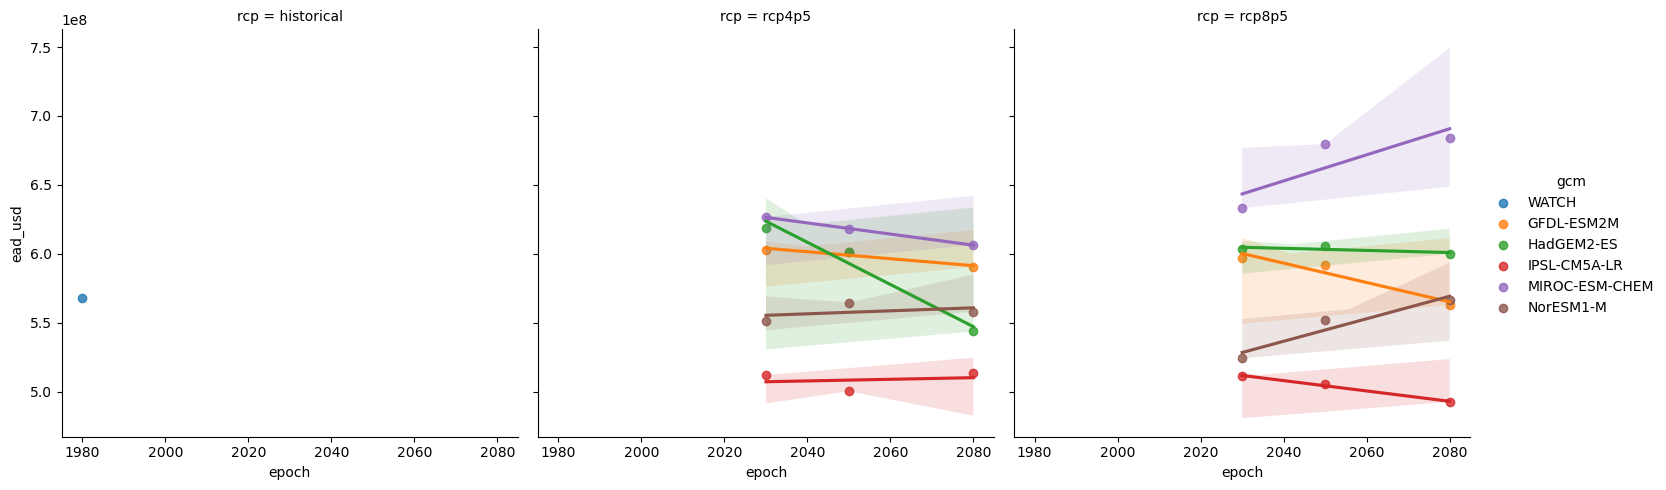

In [41]:
sns.lmplot(
    data=summary,
    col="rcp",
    x="epoch",
    y="ead_usd",
    hue="gcm",  # fit_reg=False
)